In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PowerTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from sklearn.metrics import confusion_matrix
from yellowbrick.classifier import ConfusionMatrix




# Carregue o arquivo CSV

caminho_arquivo = r'C:\Users\Andre\OneDrive\Documentos\FACENS\Reconhecimento de Padroes\AC2\bodyPerformance.csv'

# Carregue o conjunto de dados
dataset = pd.read_csv(caminho_arquivo, encoding='latin1')

# Verifique as colunas do conjunto de dados
def verificar_colunas(df):
    numero_de_colunas_esperado = 24
    print("Colunas do conjunto de dados:")
    print(df.columns)
    if len(df.columns) == numero_de_colunas_esperado:
        print("O número de colunas está correto.")
    else:
        print("O número de colunas está incorreto. Verifique a estrutura do arquivo.")

# Verifique se há valores ausentes nos dados
def verificar_valores_ausentes(df):
    valores_ausentes = df.isnull().sum().sum()
    if valores_ausentes == 0:
        print("Não há valores ausentes nos dados.")
    else:
        print(f"Há {valores_ausentes} valores ausentes nos dados. Realize o tratamento apropriado.")


dataset['gender'] = dataset['gender'].map({'M': 0, 'F': 1})

dataset['class'] = dataset['class'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3})

# Chame as funções para verificar as colunas e valores ausentes
verificar_colunas(dataset)
verificar_valores_ausentes(dataset)

Colunas do conjunto de dados:
Index(['age', 'gender', 'height_cm', 'weight_kg', 'body fat_%', 'diastolic',
       'systolic', 'gripForce', 'sit and bend forward_cm', 'sit-ups counts',
       'broad jump_cm', 'class'],
      dtype='object')
O número de colunas está incorreto. Verifique a estrutura do arquivo.
Não há valores ausentes nos dados.


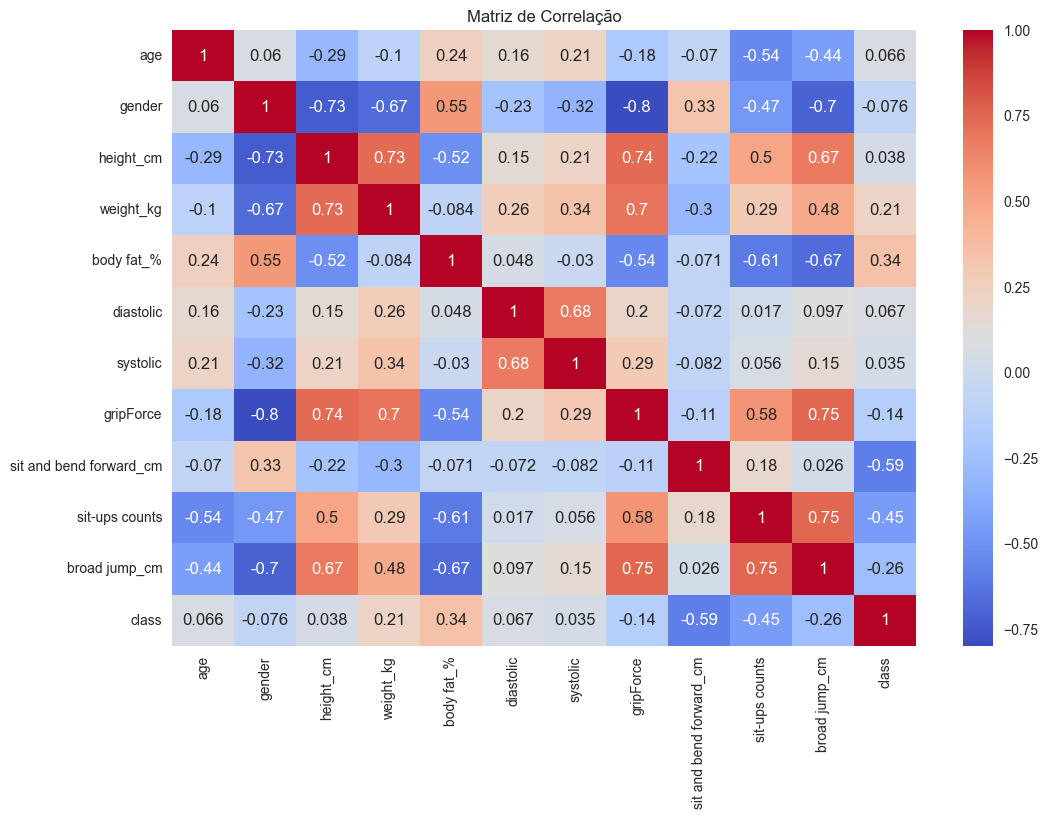

class                      1.000000
body fat_%                 0.341956
weight_kg                  0.214129
diastolic                  0.066761
age                        0.065612
height_cm                  0.037753
systolic                   0.035484
gender                    -0.075605
gripForce                 -0.136088
broad jump_cm             -0.262154
sit-ups counts            -0.452832
sit and bend forward_cm   -0.588123
Name: class, dtype: float64


In [91]:
# Crie a matriz de correlação
correlation_matrix = dataset.corr()

# Plote a matriz de correlação
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

# Identificação dos fatores mais correlacionados com a coluna alvo (substitua 'class' pelo o nome correto da coluna alvo)
target_correlation = correlation_matrix['class'].sort_values(ascending=False)
print(target_correlation)

In [92]:
# Defina as colunas numéricas relevantes para a análise
colunas_numericas_relevantes = ['height_cm', 'gripForce', 'broad jump_cm','weight_kg']

# Selecione apenas as colunas numéricas relevantes
dataset_numeric = dataset[colunas_numericas_relevantes]

# Remova linhas com valores não numéricos
dataset_numeric = dataset_numeric.apply(pd.to_numeric, errors='coerce')
dataset_numeric = dataset_numeric.dropna()

In [93]:


# Dados e divisão em treinamento/teste
X = dataset_numeric[['height_cm', 'gripForce', 'broad jump_cm']]
y = dataset_numeric['weight_kg']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Padronize os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Função para categorizar o peso em "Abaixo do Peso", "Peso Normal" e "Acima do Peso"
def categorizar_peso(peso):
    if peso < 40:
        return 'Abaixo do Peso'
    elif 60 <= peso < 80:
        return 'Peso Normal'
    elif 80 <= peso < 100:
        return 'Acima do Peso'
    else:
        return 'Obeso'

# Aplicar a função de categorização aos rótulos do conjunto de treinamento e teste
y_train = y_train.apply(categorizar_peso)
y_test = y_test.apply(categorizar_peso)

# Use um LabelEncoder para converter as categorias em valores numéricos
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Remover outliers
lof = LocalOutlierFactor(n_neighbors=20)
y_pred = lof.fit_predict(X_train)
outliers = y_pred == -1
X_train = X_train[~outliers]
y_train = y_train[~outliers]


Melhor precisão do modelo otimizado: 73.27%


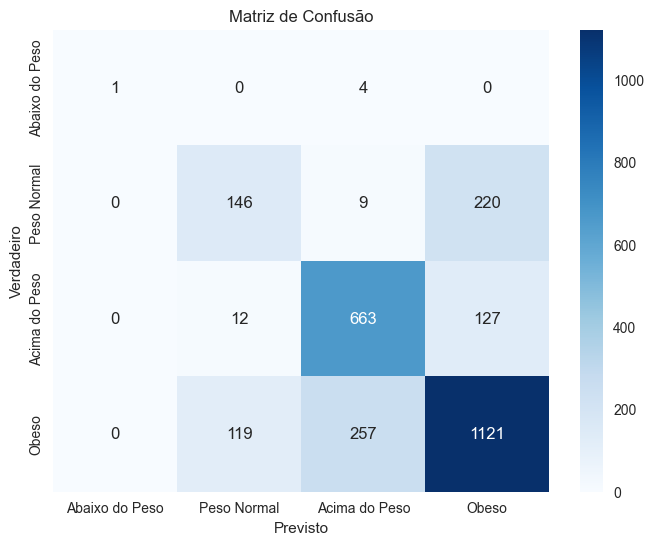

In [94]:
# Defina uma lista de valores 'k' para seleção de recursos
k_values = [2, 3]  # Ajuste o valor de 'k' conforme necessário

best_accuracy = 0
best_model = None

for k in k_values:
    # Selecione os recursos mais relevantes
    selector = SelectKBest(f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    # Transforme os recursos usando uma transformação de potência
    transform = PowerTransformer()
    X_train_selected = transform.fit_transform(X_train_selected)
    X_test_selected = transform.transform(X_test_selected)

    # Defina uma grade de hiperparâmetros para busca
    param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]}

    # Crie o classificador Naive Bayes
    naive_bayes_classifier = GaussianNB()

    # Use validação cruzada para ajustar hiperparâmetros
    grid_search = GridSearchCV(estimator=naive_bayes_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train_selected, y_train)

    best_naive_bayes = grid_search.best_estimator_  # Obtenha o melhor modelo

    # Calcule a precisão do modelo no conjunto de teste
    y_pred = best_naive_bayes.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = best_naive_bayes   

print("Melhor precisão do modelo otimizado: {:.2f}%".format(best_accuracy * 100))

# Calcule a matriz de confusão
confusion = confusion_matrix(y_test, y_pred)

# Defina os rótulos das classes
class_names = ['Abaixo do Peso', 'Peso Normal', 'Acima do Peso', 'Obeso']

# Crie um gráfico de calor da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

Precisão do modelo KNN: 71.33%


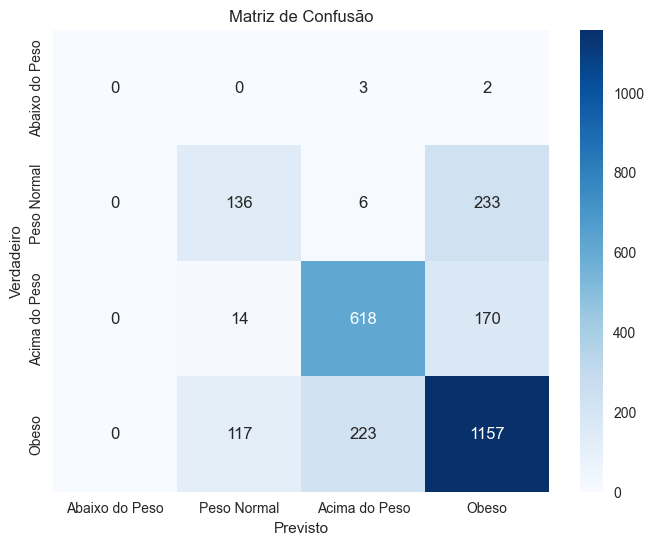

In [95]:
# Treinar o modelo KNN
knn_classifier = KNeighborsClassifier(n_neighbors=10)
knn_classifier.fit(X_train, y_train)

# Faça previsões com o conjunto de teste
y_pred = knn_classifier.predict(X_test)

# Calcule a precisão do modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisão do modelo KNN: {:.2f}%".format(accuracy * 100))
# Calcule a matriz de confusão
confusion = confusion_matrix(y_test, y_pred)

# Defina os rótulos das classes
class_names = ['Abaixo do Peso', 'Peso Normal', 'Acima do Peso', 'Obeso']

# Crie um gráfico de calor da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()


Acurácia do modelo de Rede Neural: 73.87%


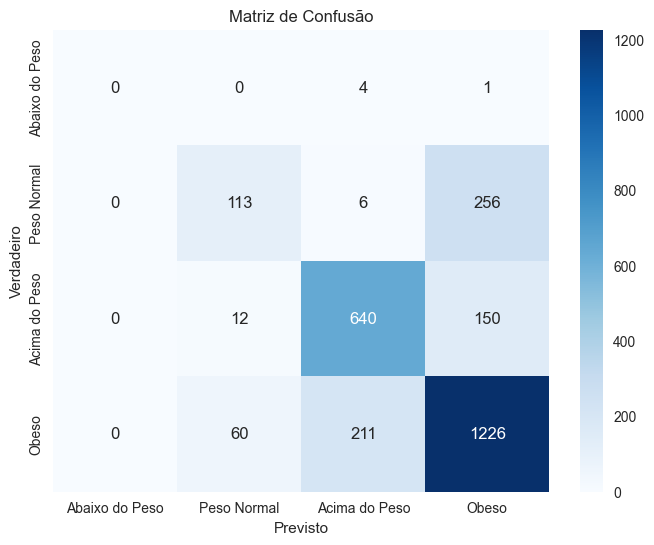

In [96]:
# Ajustar hiperparâmetros e adicionar regularização L2
mlp = MLPClassifier(hidden_layer_sizes=(200, 100), activation='relu', solver='adam', alpha=0.001,
                    max_iter=1000, random_state=42)

# Padronizar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Treinar o modelo de Rede Neural
mlp.fit(X_train_scaled, y_train)

# Fazer previsões no conjunto de teste
y_pred = mlp.predict(X_test_scaled)

# Avaliar o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia do modelo de Rede Neural: {accuracy * 100:.2f}%')

# Calcule a matriz de confusão
confusion = confusion_matrix(y_test, y_pred)

# Defina os rótulos das classes
class_names = ['Abaixo do Peso', 'Peso Normal', 'Acima do Peso', 'Obeso']

# Crie um gráfico de calor da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()